In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils import load_model_and_tokenizer, obtain_all_ice_variants, evaluate
from src.patching import prepare_diagnostic_dataset, patch_everything, extract_operands_and_operators_results, compute_pe
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = 'EleutherAI/pythia-12b-deduped-v0'
DATASET_PATH = './data/pythia_12b_data.pt'

This can be used to load a bitsandbytes version that is different from the PyTorch CUDA version.
If this was unintended set the BNB_CUDA_VERSION variable to an empty string: export BNB_CUDA_VERSION=
If you use the manual override make sure the right libcudart.so is in your LD_LIBRARY_PATH
For example by adding the following to your .bashrc: export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:<path_to_cuda_dir/lib64



### Load the model and the dataset

In [3]:
tokenizer, model = load_model_and_tokenizer(MODEL_NAME, device)
dataset = torch.load(DATASET_PATH)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model EleutherAI/pythia-12b-deduped-v0 into HookedTransformer


### Preprocess the dataset

In [5]:
dataset_no_ice, dataset_single_ice, _, _ = obtain_all_ice_variants(dataset)

### Evaluate the model on the dataset

In [8]:
results_no_ice, results_single_ice = [evaluate(tokenizer, model, data, batch_size=10, prepend_bos=True, result_format='str') for data in [dataset_no_ice, dataset_single_ice]]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [11]:
results = [results_no_ice, results_single_ice]
print("Results (No ICE, Single ICE):", [np.round(np.mean(res), 3) for res in results])

Results (No ICE, Single ICE): [0.369, 0.555]


### Prepare the data for patching

1.  Pad examples **without ICE** to the equal length with examples **with ICE**.
2.  Filter the dataset: Keep only samples that were **correctly solved with ICE** AND **incorrectly solved without ICE**.

In [12]:
diagnostic_dataset = prepare_diagnostic_dataset(tokenizer, model, dataset_single_ice, dataset_no_ice)

  0%|          | 0/420 [00:00<?, ?it/s]

For demonstration purposes, we will only use 10 samples from the diagnostic dataset.

In [13]:
diagnostic_dataset = diagnostic_dataset[:10]

print('Example entries from diagnostic dataset:')
diagnostic_dataset[:2]

Example entries from diagnostic dataset:


[{'prompt_ice': '1 + 12 + 5 = 18. 5 + 6 + 7 =',
  'correct_answer': '18',
  'correct_answer_tok': 1093,
  'prompt_no_ice': '5 + 6 + 7 =',
  'predicted_answer_ice': ' 18',
  'predicted_answer_ice_tok': 1283,
  'predicted_answer_no_ice': ' 14',
  'predicted_answer_no_ice_tok': 1638},
 {'prompt_ice': '5 + 8 + 1 = 14. 1 + 7 + 4 =',
  'correct_answer': '12',
  'correct_answer_tok': 805,
  'prompt_no_ice': '1 + 7 + 4 =',
  'predicted_answer_ice': ' 12',
  'predicted_answer_ice_tok': 1249,
  'predicted_answer_no_ice': ' 10',
  'predicted_answer_no_ice_tok': 884}]

### Residual stream patching experiments

1. Perform activation patching for all items in the diagnostic dataset

In [14]:
patching_results, clean_logit_diffs, corrupted_logit_diffs = patch_everything(model, 
                                                                              diagnostic_dataset, 
                                                                              tokenizer, 
                                                                              batch_size=1, 
                                                                              activation_name='resid_pre', 
                                                                              prepend_bos=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

2. Extract only activation patching results for main components of arithmetic equations — operands, operators, and the equal sign.

In [15]:
patching_results_operands_operators = extract_operands_and_operators_results(tokenizer, diagnostic_dataset, patching_results, prepend_bos=True)

### Plot results

In [16]:
xtick_labels = ['operand_1', 'operator_1', 'operand_2', 'operator_2', 'operand_3', 'eq', 'res', 'operand_1', 'operator_1', 'operand_2', 'operator_2', 'operand_3', 'eq']

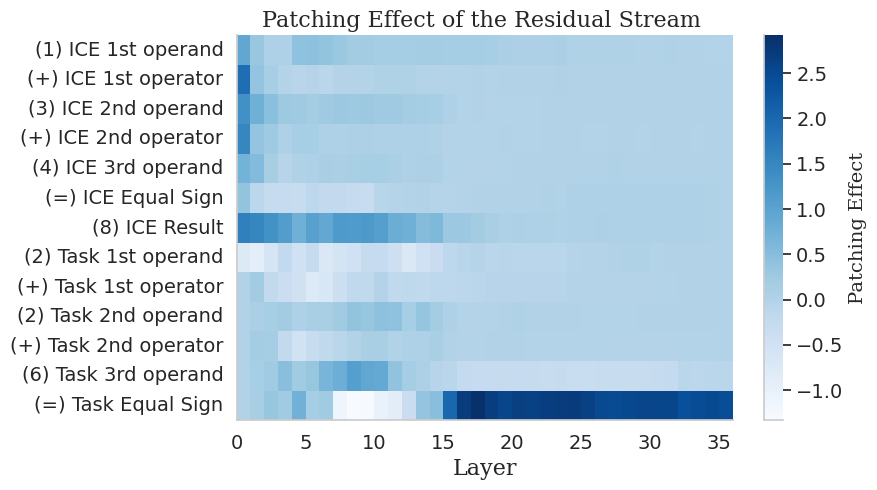

In [21]:
res = compute_pe(patching_results_operands_operators, corrupted_logit_diffs).cpu().numpy()

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']


idx = ['(1) ICE 1st operand', '(+) ICE 1st operator', '(3) ICE 2nd operand', '(+) ICE 2nd operator', '(4) ICE 3rd operand', '(=) ICE Equal Sign', '(8) ICE Result', '(2) Task 1st operand', '(+) Task 1st operator', '(2) Task 2nd operand', '(+) Task 2nd operator', '(6) Task 3rd operand', '(=) Task Equal Sign']
df = pd.DataFrame(res.T, index=idx, columns=np.arange(res.shape[0]))

vmax=np.max(res)

plt.figure(figsize=(8, 5))
sns.set_theme(font_scale=1.1)
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.heatmap(df, cmap="Blues", annot=False, fmt=".1f", cbar=True, vmax=vmax)
ax.set_xticks(range(model.cfg.n_layers))

ax.set_xticklabels(range(model.cfg.n_layers), fontsize=14, rotation=0)
plt.xlabel('Layer', fontsize=16, fontname='DeJavu Serif')

for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 5 != 0:
        label.set_visible(False)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)
plt.ylabel('')

plt.title(f'Patching Effect of the Residual Stream ', fontsize=16, fontname='DeJavu Serif')

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label("Patching Effect", fontsize=14, fontname='DeJavu Serif')

sns.despine()